In [1]:
from fastai import *
from fastai.vision import *

from ranger import Ranger

%matplotlib inline
PATH = Path('../..').resolve()

# Unify detections/nondetection catalogs

In [2]:
# detections
a40 = pd.read_csv(f'../../results/a40_detections.csv',)

a40['id'] = a40.AGCNr.apply(lambda s: f'a40_{s}')
a40.set_index('id', inplace=True)
a40.drop('AGCNr', axis=1, inplace=True)

a40['detected'] = True
a40.sample(3)

,ra,dec,z,r,detected
id,,,,,
a40_202892,161.64958,12.22028,0.02446,16.23,True
a40_200661,163.61540,9.94972,0.03094,14.82,True
a40_226305,184.35085,7.04056,0.01247,16.02,True


In [3]:
# non-detections
nsa = pd.read_csv(f'../../results/nsa_nondetections.csv',)

nsa['id'] = nsa.NSAID.apply(lambda s: f'nsa_{s}')
nsa.set_index('id', inplace=True)
nsa.drop('NSAID', axis=1, inplace=True)

nsa['detected'] = False
nsa.sample(3)

,ra,dec,z,r,detected
id,,,,,
nsa_111815,167.368154,15.940043,0.047360,16.761118,False
nsa_77051,193.990929,8.609985,0.047028,15.773900,False
nsa_65998,165.297153,12.474752,0.026952,14.179374,False


In [4]:
nsa.shape, a40.shape

((2662, 5), (2662, 5))

**Note that the two NSAID and AGCNr *numbers* are not unique!**

In [5]:
df = pd.concat((a40, nsa)).sample(frac=1)
df.sample(5)

,ra,dec,z,r,detected
id,,,,,
a40_214284,169.64583,4.71611,0.04738,16.37,True
a40_224556,182.66585,10.55333,0.04439,16.47,True
a40_200661,163.61540,9.94972,0.03094,14.82,True
a40_200484,159.08125,13.44611,0.02225,14.33,True
a40_202193,152.36624,8.91472,0.02667,16.40,True


In [49]:
# df.to_csv('../../results/detectability_sample.csv', index=True)

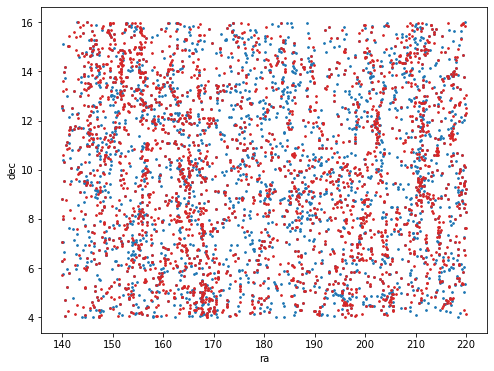

In [10]:
plt.figure(figsize=(8,6))
df[df.detected].plot.scatter('ra', 'dec', c='C0', ax=plt.gca(), s=3)
df[~df.detected].plot.scatter('ra', 'dec', c='C3', ax=plt.gca(), s=3)

# Building a model

In [7]:
df = pd.read_csv('../../results/detectability_sample.csv')

In [37]:
bs = 32
sz = 56

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [38]:
il = ImageList.from_df(df, path=PATH, folder='images-detectability', suffix='.jpg', cols='id')

src = (il.split_by_rand_pct(0.2)
         .label_from_df(cols='detected')
)

data = (src.transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(image_stats)
)

In [39]:
model = simple_cnn([3, 16, 32, 2])

In [45]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    metrics=[accuracy],
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)



In [46]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


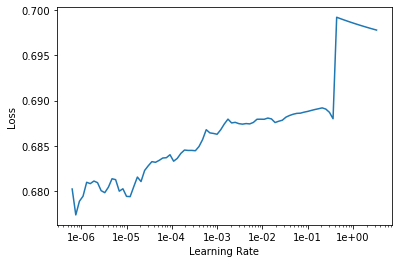

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.672251,0.662297,0.626880,00:08
